In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("spotify_churn_dataset.csv")

In [3]:
df=df.drop(columns=['user_id','is_churned','gender','country','device_type'])

In [4]:
df

,age,subscription_type,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening
0,54,Free,26,23,0.20,31,0
1,33,Family,141,62,0.34,0,1
2,38,Premium,199,38,0.04,0,1
3,22,Student,36,2,0.31,0,1
4,29,Family,250,57,0.36,0,1
...,...,...,...,...,...,...,...
7995,44,Student,237,36,0.30,0,1
7996,34,Premium,61,64,0.59,0,1
7997,17,Free,81,62,0.33,5,0
7998,34,Student,245,94,0.27,0,1


In [5]:
features = df.drop(columns='subscription_type')

In [6]:
#encoding
df_encoded = pd.get_dummies(df,columns=['subscription_type'],drop_first=True)

In [7]:
df_encoded

,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,subscription_type_Free,subscription_type_Premium,subscription_type_Student
0,54,26,23,0.20,31,0,True,False,False
1,33,141,62,0.34,0,1,False,False,False
2,38,199,38,0.04,0,1,False,True,False
3,22,36,2,0.31,0,1,False,False,True
4,29,250,57,0.36,0,1,False,False,False
...,...,...,...,...,...,...,...,...,...
7995,44,237,36,0.30,0,1,False,False,True
7996,34,61,64,0.59,0,1,False,True,False
7997,17,81,62,0.33,5,0,True,False,False
7998,34,245,94,0.27,0,1,False,False,True


In [8]:
from sklearn.preprocessing import StandardScaler



# Scale
scaler = StandardScaler()

X_scaled = scaler.fit_transform(features)


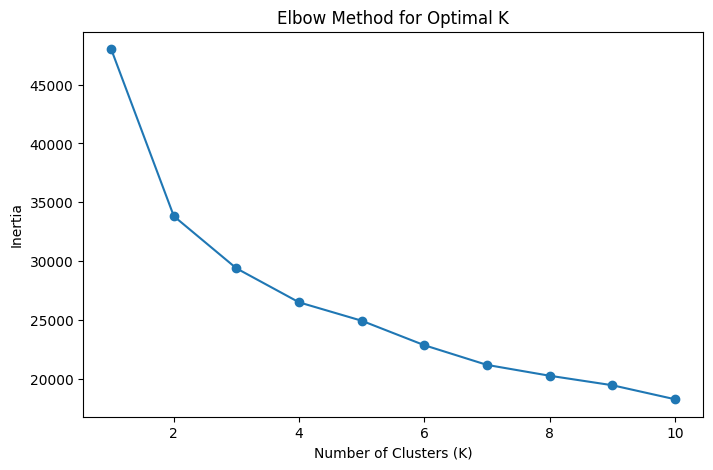

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11), inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


In [10]:
#insights
'''
K was chosen as 3 because inertia decreases sharply up to K = 3 and shows diminishing improvement beyond that point, 
indicating that additional clusters do not add meaningful structure.

'''

'\nK was chosen as 3 because inertia decreases sharply up to K = 3 and shows diminishing improvement beyond that point, \nindicating that additional clusters do not add meaningful structure.\n\n'

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['cluster'] = clusters
df[['cluster']].value_counts()


cluster
1          3013
2          2969
0          2018
Name: count, dtype: int64

In [12]:
cluster_summary = df.groupby('cluster').mean(numeric_only=True)
cluster_summary


,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening
cluster,,,,,,
0,37.287909,154.997027,49.204163,0.300922,27.52775,0.0
1,38.437106,152.292400,50.966810,0.151915,0.00000,1.0
2,37.130010,155.239138,49.902661,0.449997,0.00000,1.0


In [13]:
#insights
'''
K-Means clustering identified clear user segments based on listening behavior. cluster 1 and 2 are premium users and cluster 0 is free user.
cluster 1 is loyal users and main listeners(low skip rate) and cluster 2 is exploratory type users because of their high skiprate. '''

'\nK-Means clustering identified clear user segments based on listening behavior. cluster 1 and 2 are premium users and cluster 0 is free user.\ncluster 1 is loyal users and main listeners(low skip rate) and cluster 2 is exploratory type users because of their high skiprate. '

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)


In [15]:
pca.explained_variance_ratio_ #PCA 1 -variance of 31% and PCA 2 variance of 17% total 48% means-retain 48% of the information (variance) in the data.

array([0.31321795, 0.17019878])

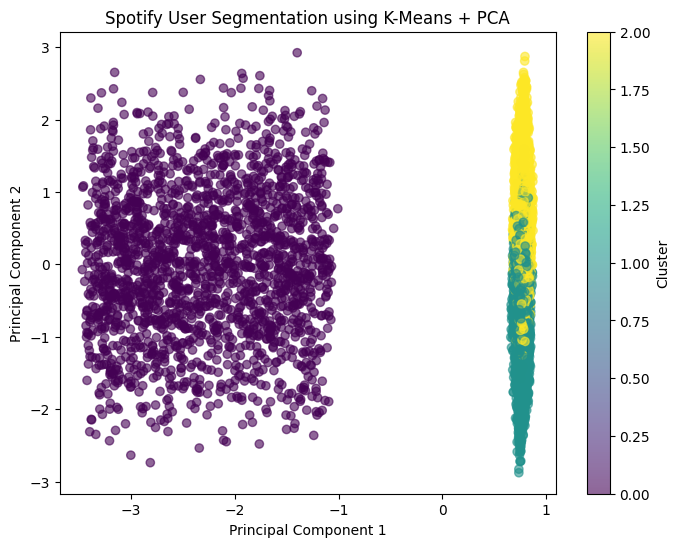

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df['cluster'],
    cmap='viridis',
    alpha=0.6
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Spotify User Segmentation using K-Means + PCA")
plt.colorbar(label="Cluster")
plt.show()


In [17]:
#insights
'''
Principal Component Analysis (PCA) was applied to reduce high-dimensional listening behavior into two components for visualization. 
The first two principal components explained approximately 48% of the total variance '''

'\nPrincipal Component Analysis (PCA) was applied to reduce high-dimensional listening behavior into two components for visualization. \nThe first two principal components explained approximately 48% of the total variance '

In [18]:
#DBSCAN

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.7, min_samples = 10)
dbscan_labels = dbscan.fit_predict(X_scaled)
df['dbscan_cluster'] = dbscan_labels
df['dbscan_cluster'].value_counts()

dbscan_cluster
 0     5982
-1     1910
 5       18
 3       11
 10      11
 6       10
 9       10
 1       10
 2       10
 4       10
 7       10
 8        8
Name: count, dtype: int64

In [19]:
#insights
'''
DBSCAN was used to explore density-based clustering and identify anomalous listening behavior.
The algorithm revealed one dominant dense cluster representing mainstream users, while labeling a significant portion 
of users as noise and forming several small clusters of extreme behavior.

This indicates that Spotify user behavior contains a strong core pattern with many irregular or edge-case users.
DBSCAN is therefore more suitable for outlier and anomaly detection than for persona-based segmentation in this dataset. '''

'\nDBSCAN was used to explore density-based clustering and identify anomalous listening behavior.\nThe algorithm revealed one dominant dense cluster representing mainstream users, while labeling a significant portion \nof users as noise and forming several small clusters of extreme behavior.\n\nThis indicates that Spotify user behavior contains a strong core pattern with many irregular or edge-case users.\nDBSCAN is therefore more suitable for outlier and anomaly detection than for persona-based segmentation in this dataset. '

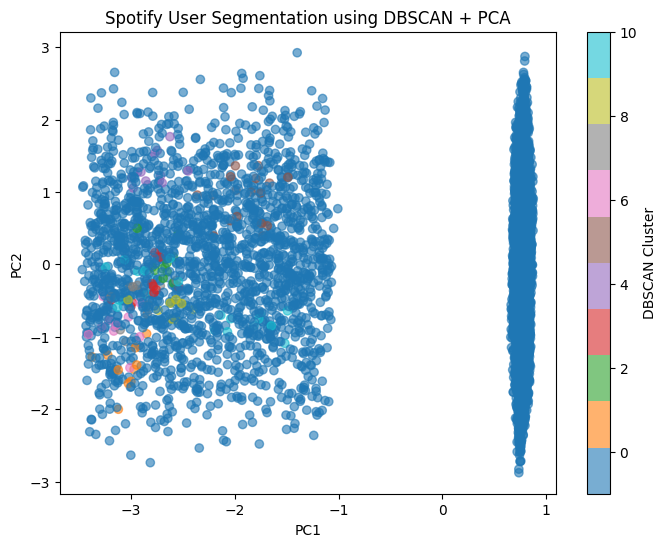

In [20]:
#visualize DBSCAN using PCA

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df['dbscan_cluster'],
    cmap='tab10',
    alpha=0.6
)
plt.title("Spotify User Segmentation using DBSCAN + PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="DBSCAN Cluster")
plt.show()


In [21]:
#hierarchical clustering

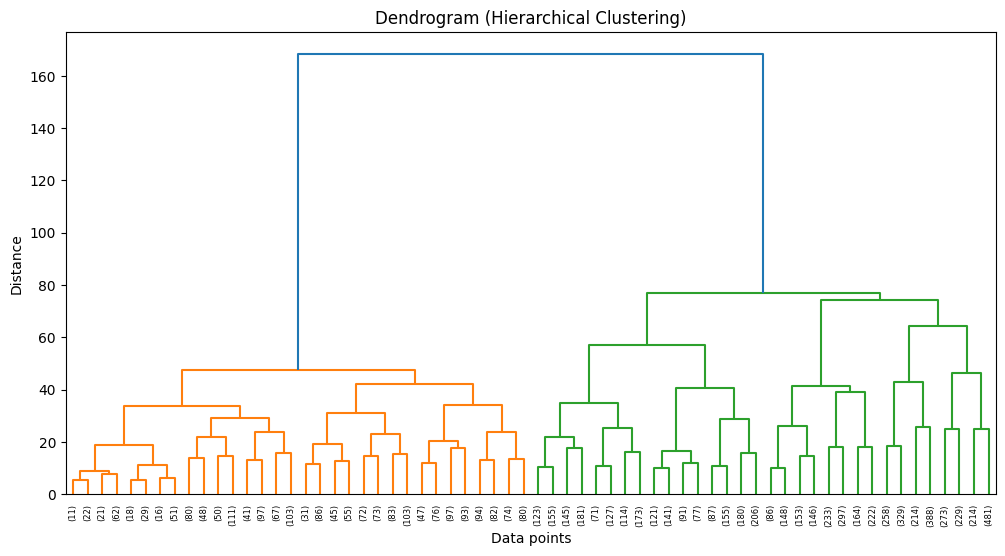

In [22]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sch.dendrogram(
    sch.linkage(X_scaled, method='ward'),
    truncate_mode='level',
    p=5
)
plt.title("Dendrogram (Hierarchical Clustering)")
plt.xlabel("Data points")
plt.ylabel("Distance")
plt.show()


In [23]:
#insights
'''
Hierarchical clustering was applied to understand the multi-level structure of user behavior.
The dendrogram revealed a large distance jump, indicating the presence of two major behavioral families,
with further sub-structure visible at lower distances. '''

'\nHierarchical clustering was applied to understand the multi-level structure of user behavior.\nThe dendrogram revealed a large distance jump, indicating the presence of two major behavioral families,\nwith further sub-structure visible at lower distances. '

In [24]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(
    n_clusters=2,
    linkage='ward'
)

hc_labels = hc.fit_predict(X_scaled)
df['hc_cluster'] = hc_labels

df['hc_cluster'].value_counts()


hc_cluster
0    5982
1    2018
Name: count, dtype: int64

In [25]:
df.groupby('hc_cluster').mean(numeric_only=True)


,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,cluster,dbscan_cluster
hc_cluster,,,,,,,,
0,37.788365,153.754931,50.438649,0.299860,0.00000,1.0,1.496322,0.0000
1,37.287909,154.997027,49.204163,0.300922,27.52775,0.0,0.000000,-0.6556


In [26]:
"shows the free users and premium users(offline users)"

'shows the free users and premium users(offline users)'

In [27]:
#insights
'''
Multiple unsupervised learning techniques were applied to analyze Spotify listening behavior.
K-Means was used for primary persona discovery, PCA enabled interpretability through visualization, DBSCAN highlighted anomalous users,
and hierarchical clustering validated the multi-level structure of the data. 
Together, these methods provide a comprehensive understanding of user behavior from different analytical perspectives. '''

'\nMultiple unsupervised learning techniques were applied to analyze Spotify listening behavior.\nK-Means was used for primary persona discovery, PCA enabled interpretability through visualization, DBSCAN highlighted anomalous users,\nand hierarchical clustering validated the multi-level structure of the data. \nTogether, these methods provide a comprehensive understanding of user behavior from different analytical perspectives. '